In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import vmap, jit, jacrev
import jax.numpy as jnp
from pathlib import Path
import numpy as np
from einops import rearrange
import jax
import matplotlib.pyplot as plt
from hflow.misc.plot import scatter_movie, imshow_movie, line_movie
from hflow.run import build
from hflow.io.load import load_single, load_multi
import random
from hflow.misc.jax import batchmap, hess_trace_estimator, tracewrap, meanvmap

In [119]:
cfg, row = load_single('lin', 'EWhN_172746477553')
key, train_data, test_data, loss_fn, arg_fn, s, params_init = build(cfg)




In [120]:

train_sols, train_mus, t_eval = train_data
train_sol = train_sols[-1]
opt_params = row['last_params']
mu = jnp.asarray(row['test_mus'][-1])
t_int = row['t_int']
# param_history = row['param_history']
omega = cfg.data.omega
t_sol = np.linspace(0,1,len(train_sol))

In [121]:
s_n, s_t = 50, 1
train_sol_sub = jnp.asarray(train_sol[::s_t, ::s_n])
t_eval_sub = jnp.asarray(t_eval[::s_t])
train_sol_sub.shape, t_eval_sub.shape, mu.shape

((1001, 200, 2), (1001, 1), (1,))

In [122]:
def s_sep(mu, x, t, params):
    mu_t = jnp.concatenate([mu, t])
    return s(mu_t, x, params)# -  s(mu_t, x*0, params)

s_Vx = vmap(s_sep, (None, 0, None, None))
s_Vxt = vmap(s_Vx, (None, None, 0, None))


s_Ex = meanvmap(s_sep, in_axes=(None, 0, None, None))
s_Ex_Vt = vmap(s_Ex, (None, 0, 0, None))


s_dx = jacrev(s_sep, 1)
s_dx_sq = lambda *args: jnp.sum(s_dx(*args)**2)
sq_dx_Ex = meanvmap(s_dx_sq, in_axes=(None, 0, None, None))

s_dt = jacrev(s_sep, 2)
s_dt_Ex = meanvmap(s_dt, in_axes=(None, 0, None, None))


def q(t, data_x, params):
    S_dt = s_dt_Ex(mu, data_x, t, params)
    S_grad = sq_dx_Ex(mu, data_x, t, params)
    return 0.5*S_grad+S_dt

q_vt = vmap(q, (0, 0, None))

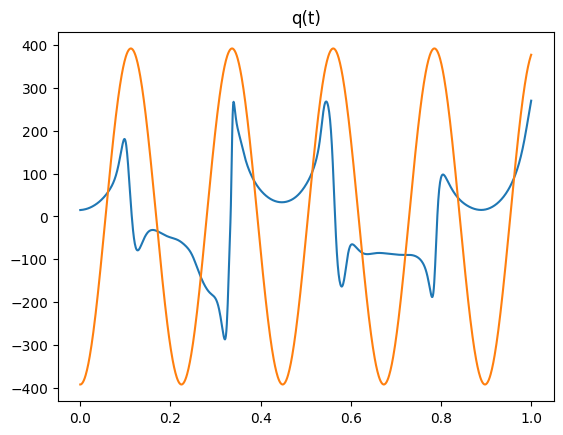

(Array(1.14064286, dtype=float64),
 Array(-3.79596653, dtype=float64),
 Array(13.68152172, dtype=float64))

In [123]:
def analytic_qt(t, omega, d=2):
    return - 2 * d / 4 * 2 * omega * omega * jnp.cos(2 * omega * t)

Es = s_Ex_Vt(mu, train_sol_sub, t_eval_sub , opt_params)

q_t = q_vt(t_eval_sub, train_sol_sub, opt_params)
q_t = np.squeeze(q_t)



plt.plot(t_eval_sub, q_t)
plt.plot(t_eval_sub, analytic_qt(t_eval_sub, omega))
plt.title("q(t)")
plt.show()

q_t_analytic = analytic_qt(t_eval_sub, omega)

np.mean(q_t), np.mean(q_t_analytic), Es[-1] - Es[0]

In [153]:
t_simp, w_simp = get_simpsons(len(t_eval_sub))
q_t = q_vt(t_eval_sub, train_sol_sub, opt_params)
q_t = np.squeeze(q_t)
integral_true = np.sum(q_t*w_simp)
print(f'true_integral: {integral_true:.4f}', )

true_integral: 0.9987


In [184]:
from hflow.train.sample import interplate_in_t, get_simpsons
from hflow.misc.misc import gauss_quadrature_weights_points
N = 256
# mc 
def integrate_qt(pts, weights):
    pts = np.squeeze(pts)
    pts = np.sort(pts)
    ss = interplate_in_t(train_sol, t_sol, pts)
    q_t = q_vt(pts.reshape(-1,1), ss[:, ::s_n], opt_params)
    q_t = np.squeeze(q_t)
    integral = np.sum(q_t*weights)
    return integral, q_t



In [185]:
t_mc = np.random.uniform(low=0.0,high=1.0, size=(N,))
t_mc = np.sort(t_mc)
w_mc = np.ones_like(t_mc) * 1/len(t_mc)

mc_int, mc_qt = integrate_qt(t_mc, w_mc)
print(f'mc_integral: {mc_int:.3f}', )

mc_integral: -6.430


In [190]:
t_simp, w_simp = get_simpsons(N-1)
simp_int, simp_qt = integrate_qt(t_simp, w_simp)
print(f'simp_integral: {simp_int:.3f}', )

simp_integral: 0.929


In [191]:
t_gauss, w_gauss = gauss_quadrature_weights_points(N)
gauss_int, gauss_qt = integrate_qt(t_gauss, w_gauss)
print(f'gauss_integral: {gauss_int:.3f}', )

gauss_integral: 0.941


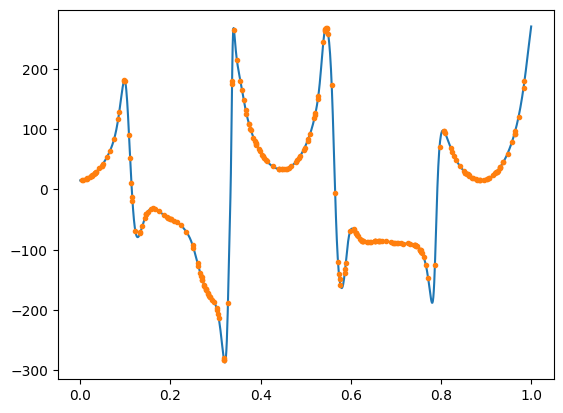

In [192]:

plt.plot(t_eval_sub, q_t)
plt.plot(t_mc, mc_qt, '.')
plt.show()

In [196]:
from tqdm.auto import tqdm
qs = []
param_history = row['param_history']
for p in tqdm(param_history[::20]):
    q_t = q_vt(t_eval_sub, train_sol_sub, p)
    q_t = np.squeeze(q_t)
    qs.append(q_t)

qs = np.asarray(qs)
    

  0%|          | 0/50 [00:00<?, ?it/s]

In [199]:
print(row['optimizer-iters'], row['mean_analytic_w_dist_1'])

line_movie(qs)

10000 0.00138479162731681


In [78]:
print(row['optimizer-iters'], row['mean_analytic_w_dist_1'])
line_movie(qs)


1000 0.0019000401001515782


In [76]:
# nx = 128
# x1, x2 = jnp.linspace(0.0, 1.0, nx), jnp.linspace(0.0, 1.0, nx)
# m_grids = jnp.meshgrid(x1, x2,  indexing='ij')
# x_grid = jnp.asarray([m.flatten() for m in m_grids]).T


# s_time = s_Vxt(mu, x_grid, t_eval_sub, opt_params).reshape(-1, nx, nx)

# imshow_movie(s_time, live_cbar=True)